# Randomness

[Measure theory](https://en.wikipedia.org/wiki/Measure_(mathematics)) studies things that are measurable (e.g. length, area, volume) but generalized to various dimensions. The _measure_ tells us how things are distributed and concentrated in a mathematical space.

::::{admonition} Example: The Sphere
Any point on the sphere can be specified by three parameters: e.g. (x,y,z) in Cartesian coordinates or $(\rho, \theta, \phi)$ in spherical coordinates.

Suppose we wish to find the volume. The first thought may be to integrate each parameter over its full range:

$$
V = \int_0^{r} \int_0^{2\pi} \int_0^{\pi} d\rho~ d\phi~ d\theta = 2\pi^2 r
$$

But this is clearly wrong (the volume of a sphere with radius $r$ is $\frac{4}{3}\pi r^3$.) Taking the integral in this way does not account for the _structure_ of the sphere with respect to the parameters. If you have ever studied multivariate calculus this may sound familiar.

```{image} volume-element.png
:align: center
```

The issue is that although the difference $d\theta$ and $d\phi$ are the same, there is more _stuff_ near the equator of the sphere. Therefore the integral must account for the value of $\theta$. Similarly, as we are closer to the center of the sphere there is less _stuff_ compared to as we go further away from the center. Hence we must also include the radius $\rho$ as part of the integral. 

So the correct integral is:

$$
V = \int_0^r \int_0^{2\pi} \int_0^{\pi} \rho^2 \sin \theta~ d\rho~ d\phi~
d\theta = \frac{4}{3}\pi r^3
$$

The extra terms $\rho^2\sin\theta$ is the _measure_. The measure weight portions of the sphere differently depending on where they are in the sphere.

::::

Although the _measure_ tells us how to properly integrate, is also tells us another important fact: _how to sample points in the spae uniformly as random_. We cannot simply take each parameter and sample it from the uniform distribution -- this does not take into account the spread of the space. The measure tells us the distribution of each parameters and let us obtain something truly uniform.

## Haar Measure

Quantum evolutions (and operations in quantum computing) are described by unitary matrices. Just like the sphere, unitary matrices can be expressed in terms of a fixed set of parameters. For example, a qubit operation can be written as:

$$
\begin{align}
U(\alpha, \theta, v_x, v_y, v_z) = e^{i\alpha} \exp(-i \theta/2 \vec{v} \cdot \vec{\sigma}) &= \exp[-i \theta/2 (v_x \sigma_x + v_y \sigma_y + v_z \sigma_z)] \\
&= \cos(\theta/2) I - i \sin(\theta/2) (v_x \sigma_x + v_y \sigma_y + v_z \sigma_z)
\end{align}
$$

where $v_x^2 + v_y^2 + v_z^2 = 1$. We ignore $e^{i\alpha}$ because it is a global phase. So we are left with four parameters. But because we have the constraint that $v_x^2 + v_y^2 + v_z^2 = 1$, we only need a total of **3 parameters** to describe a single qubit operation.

In fact we can write any unitary matrix (ignoring global phase) of size $N \times N$ as:

$$
U(\vec{l}) = \exp(-i \vec{l} \cdot \vec{\Lambda})
$$

where $\vec{\Lambda}$ contains $N^2 -1$ _traceless Hermitian_ operators that define space, similar to the Pauli matrices for the case $N=2$. 


For a dimension $N$, the unitary matrix of size $N \times N$ form the unitary group $U(N)$. 

```{note}
Because we ignored the global phase, the operations we provided are technically $SU(N)$ the _special_ unitary group, where $det(U) = 1$. 
```

Just like the points of the sphere, we can perform operations on the unitary group: such as integration, functions, and sample uniformly. But just like the sphere, we have to add the _measure_ in order to properly account for the different weights in different regions of the space. This is known as the _Haar measure_, is often denoted as $\mu_N$.

$\mu_N$ tells us how to weight the elements of $U(N)$. So for example, if we have some function $f$ acting on the elements of $U(N)$ and we would like to integrate over this group, we would have:

$$
\int_{V \in U(N)} f(V) d\mu_N(V).
$$

### Example: qubit

Let us consider the following task: _generate a random qubit state_. To do this let us generate a Haar-random unitary and then apply it an initial state (e.g. $\ket{0}$). 

First let us do this incorrectly. To make things easier, let us use the following representation of a single-qubit gate:

$$
U(\theta, \phi, \lambda) = \begin{bmatrix} \cos(\theta/2) & -e^{i\lambda} \sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda + i \phi} \cos(\theta/2)
\end{bmatrix}
$$

In [1]:
from jupyterquiz import display_quiz
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bad_random_qubit_unitary():
    phi, theta, lam = 2 * np.pi * np.random.uniform(size=3)
    U = np.array([
            [np.cos(theta/2), -np.exp(-1j * lam) * np.sin(theta/2)],
            [np.exp(1j * phi) * np.sin(theta/2), np.exp(1j * (phi + lam) * np.cos(theta/2))]
        ])
    return U

samples = 1000

bad_random_unitaries = [bad_random_qubit_unitary() for _ in range(samples)]
bad_random_states = [U[:,0] for U in bad_random_unitaries]

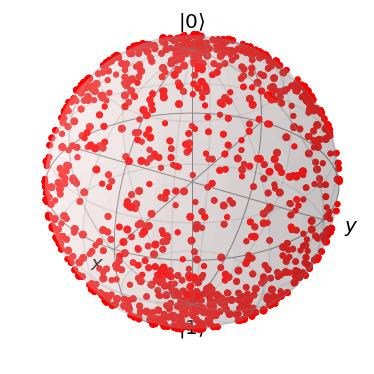

In [3]:
states = [qp.Qobj(s) for s in bad_random_states]
b = qp.Bloch()
b.point_color = ['#ff0000']
b.point_marker = ['o']
b.add_states(states, kind='point')
b.show()

Note that although we uniformly sampled our parameters, the output states cluster around the poles of the sphere. Now let us properly sample from the proper Haar measure.

Unlike the regular sphere, our sphere has a fixed radius of 1, so we need not worry about this parameter. However, similar to the regular sphere, we need to worry about $\theta$. Since the adjustment is identical to the regular sphere, we can use $\sin\theta$. Hence, in order to uniformly sample $\theta$ we need to use the distribution $\mathrm{Pr}(\theta) = \sin \theta$.

In [4]:
from scipy.stats import rv_continuous

class sin_theta_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)

sin_theta_sampler = sin_theta_dist(a=0, b=np.pi)

def haar_random_qubit_unitary():
    phi, lam = 2 * np.pi * np.random.uniform(size=2)
    theta = sin_theta_sampler.rvs(size=1)
    U = np.array([
        [np.cos(theta/2), -np.exp(-1j * lam) * np.sin(theta/2)],
        [np.exp(1j * phi) * np.sin(theta/2), np.exp(1j * (phi + lam) * np.cos(theta/2))]
    ])
    return U

haar_random_unitaries = [haar_random_qubit_unitary() for _ in range(samples)]
haar_random_states = [U[:,0] for U in haar_random_unitaries]

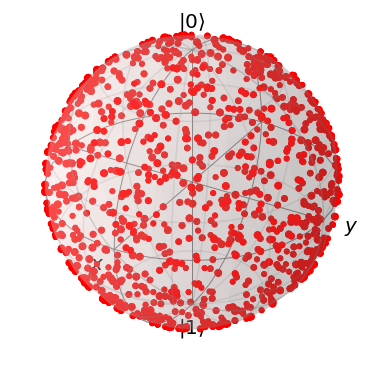

In [5]:
states = [qp.Qobj(s) for s in haar_random_states]
b = qp.Bloch()
b.point_color = ['#ff0000']
b.point_marker = ['o']
b.add_states(states, kind='point')
b.show()

As we can see, by using the correct measure, our qubit states are now uniformly distributed over the sphere. Explicitly, our Haar measure is:

$$
d\mu_2 = \sin \theta d\theta \cdot d\phi \cdot d\lambda.
$$

### Example: arbitrary dimension

Following [arXiv:math-ph/0609050](https://arxiv.org/abs/math-ph/0609050), we can use the QR decomposition of a complex-valued matrix to generate Haar-random unitary matrices. This actually implemented in [scipy.stats.unitary_group](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.unitary_group.html).

In [6]:
def haar_random_unitary(N, fixed=True):
    R, I = np.random.normal(size=(N,N)), np.random.normal(size=(N,N))
    Z = R + 1j * I

    Q, R = np.linalg.qr(Z)

    if fixed:
        L = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])
        Q = Q @ L
    
    return Q

N = 10
rand = [haar_random_unitary(N) for _ in range(samples)]
rand_not_fixed = [haar_random_unitary(N, fixed=False) for _ in range(samples)]

As explained in [arXiv:math-ph/0609050](https://arxiv.org/abs/math-ph/0609050), the solution to the QR decomposition is not unique. We can take any unitary diagonal matrix $\Lambda$, and alter the decomposition as $QR = Q \Lambda \Lambda^\dagger R = Q^\prime R^\prime$. To insure the unitary matrices are indeed Haar-random, we need to fix a particular $\Lambda$ which depends on $R$. 

Another fact is that the eigenvalues of a Haar-random unitary matrices should be uniform. And the eigenvalues of a unitary matrix are given as $e^{i\theta}$. Let us check that using the QR-decomposition method our $\theta$ eigenvalues are indeed uniform.

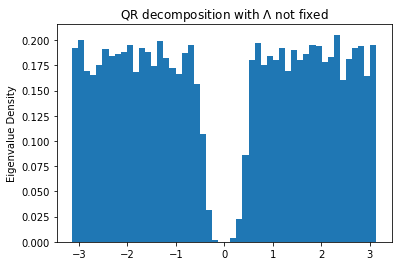

In [7]:
eigs_rand = np.array([np.linalg.eigvals(r) for r in rand_not_fixed]).flatten()

hist = plt.hist(np.angle(eigs_rand), 50, density=True)
plt.ylabel("Eigenvalue Density")
plt.title(r"QR decomposition with $\Lambda$ not fixed")
plt.show()

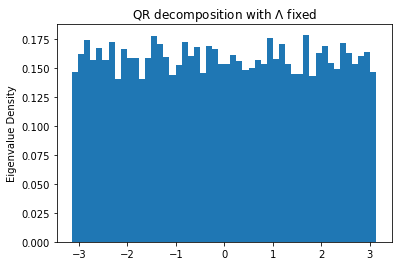

In [8]:
eigs_rand = np.array([np.linalg.eigvals(r) for r in rand]).flatten()

hist = plt.hist(np.angle(eigs_rand), 50, density=True)
plt.ylabel("Eigenvalue Density")
plt.title(r"QR decomposition with $\Lambda$ fixed")
plt.show()

We have successfully generated Haar-random unitary matrices as shown by the uniform distribution of their eigenvalues.

<!-- ### Random unitary: GOE and Matrix Diagonalization 

```{code-cell} ipython3
def goe_eigs(N = 10):
    A = np.random.randn(N, N)
    B = (A + A.T) /2
    #for i in range(len(B)):
    #    B[i,i] = 2 * B[i,i]
    E, U = np.linalg.eig(B)

    assert np.allclose(U @ U.conj().T, np.eye(N))

    D = np.linalg.eigvals(U)  
    return np.angle(D)

eigs_rand = np.array([goe_eigs() for _ in range(samples)]).flatten()

hist = plt.hist(eigs_rand, 100, density=True)
plt.plot()
``` -->


## Twirling



```{important}
Twirling a quantum channel $\mathcal{E}$ consists of averaging $\mathcal{E}$ under the composition $\mathcal{U} \circ \mathcal{E} \circ \mathcal{U}^\dagger$ for unitary operations $U(\rho) = U \rho U^\dagger$ chosen according to some probability distribution. The average channel

$$
\begin{align}
\mathcal{E}_T(\rho) &= \int_{U(N)} \mathcal{U} \circ \mathcal{E} \circ \mathcal{U}^\dagger(\rho) dU \\
&=\int_{U(N)} U^\dagger \mathcal{E}(U\rho U^\dagger) U dU
\end{align}
$$(eq:continuous-twirl)

is known as the _twirled channel_.

When the distribution over unitaries is _discrete_ we have

$$
\mathcal{E}(\rho) = \sum_i \mathrm{pr}(\mathcal{U}_i) \mathcal{U}_i \circ \mathcal{E} \circ \mathcal{U}_i^\dagger(\rho)
$$

```

Sampling from the uniform Haar-measure $\mu_N$, {eq}`eq:continuous-twirl` becomes

$$
\mathcal{E}_T(\rho) = \int_{U(N)} U^\dagger \mathcal{E}(U\rho U^\dagger) U d\mu_N(U).
$$

Intuitively, because all the elements are from the full unitary group, we would expect that the resulting channel contains a large amount of symmetry lettings us describe with it a small number of parameters. And indeed! The resulting operation can be described as the depolarizing channel

$$
\mathcal{E}_T(\rho) = p \rho + (1-p) \frac{1}{N}
$$

where $p \in [0, 1]$.

## Average Gate Fidelity

In many instances it is useful to estimate how "close" a quantum operation is to
a given unitary operation. For instance during a quantum computation one may
want to implement the unitary gate $U$ and, as with any physical implementation,
this will not be perfect. Thus the resulting operation will be represented by a
channel $\mathcal{E}$. It would be useful to have an idea of how well $\mathcal{E}$ approximates $\mathcal{U}$. As
noted previously there are many different measures of how close two quantum
operations (e.g. the fidelity and trace distance). One important measure is related to the fidelity and is called
the average gate fidelity.

<!-- Suppose, our quantum computer performed a quantum operator $\mathcal{E}$ and we wish to find how _close_ it was to our desired unitary operation $U$. Well this requires integrating over a uniform (Haar-random) space! -->

<!-- $$
F(\mathcal{E}, U) = \int \bra{\psi}U^\dagger \mathcal{E} U \ket{\psi} d\psi
$$ -->

The average gate fidelity between $\mathcal{E}$ and $\mathcal{U}$, $\overline{{{F_{g}}}}({\mathcal E},\mathcal U)$ is given by

$$
\overline{{{F_{g}}}}({\mathcal E},\mathcal U)=\int d\psi\;t r\left({\cal U}\left(|\psi\rangle\langle\psi|\right){\mathcal E}\left(|\psi\rangle\langle\psi|\right)\right).
$$

The integral is over the unitarily Fubini-Study measure on pure states. We can rewrite this expression as

$$
\begin{align}
\overline{{{F_{g}}}}(\cal E, \cal U)&=\int d\psi\;t r\left(U\left(|\psi\rangle\langle\psi|\right)\Lambda\circ U\left(|\psi\rangle\langle\psi|\right)\right) \\
&= \int d\psi\,t r\left(U|\psi\rangle\langle\psi|U^{-1}\Lambda\left(U|\psi\rangle\langle\psi|U^{-1}\right)\right)
\end{align}
$$

where $\Lambda$ is the cumulative noise operator 

$$
\Lambda = \mathcal{E} \circ \mathcal{U}^{-1},
$$

and $U$ is the unitary Kraus operator for $\mathcal{U}$.

If we twirl $\Lambda$ we can then write

$$
\begin{align}
\overline{{{F_{g}}}}(\cal E, \cal U)&=\int_{\mathcal{Q}_{\cdot}}\!\!d\psi\,t r\left(|\psi\rangle\langle\psi\,|U^{-1}\left(\Lambda\left(U|\psi\rangle\langle\psi|U^{-1}\right)\right)U\right) \\
&=\int d\psi\;t r\left(|\psi\rangle\langle\psi|U^{-1}\circ\Lambda\circ U\left(|\psi\rangle\langle\psi|\right)\right).
\end{align}
$$


As derived in [arXiv:quant-ph/0205035](https://arxiv.org/abs/quant-ph/0205035), we can express this as

$$
\begin{align}
\overline{{{F_{g}}}}(\mathcal{E}, \mathcal{U}) &= \mathrm{Tr}\left[\rho \left( p\rho + (1-p)\frac{1}{N} \right) \right] \\
&= p + \frac{1-p}{N} \\
&= \frac{\sum_{k}|\mathrm{Tr}(A_{k})|^{2}+N}{N^{2}+N}
\end{align}
$$

where $\{ A_k \}$ are a set of Kraus operators for $\mathcal{E}$. 

p is called the noise strength parameter and characterizes how well $\mathcal{E}$ approxi-
mates \mathcal{U}. If $p$ is close to 1, then $\mathcal{E}$ approximates $\mathcal{U}$ well, while if p is close to 0 then $\mathcal{E}$ does not resemble $\mathcal{U}$.

### The Protocol

Let us now express the protocol for estimating $\overline{{{F_{g}}}}(\mathcal{E}, \mathcal{U})$.

We have

$$
\overline{{{F_{g}}}}({\mathcal{E}},{\cal{U}})= \int_{U(N)} \mathrm{Tr} \left(U\rho U^{-1} (\Lambda (U\rho U^{-1}))\right)
$$

which is the average over the unitary group of the function $f : U(N) \mapsto \mathbb{R}$ defined by

$$
f(U)=\mathrm{Tr}\left(\rho\,U^{-1}\left(\Lambda\left(U\rho U^{-1}\right)\right)U\right).
$$

$\rho$ may be taken as the computation basis $\ket{0} ... \ket{0}\ket{0}\bra{0}...\bra{0}\bra{0}$. This essentially tells us that if choose a unitary operator at random and implement it, then $f(U)$ will be close to the average $\overline{{{F_{g}}}}({\mathcal{E}},{\cal{U}})$ in that

$$
f(U)=p+{\frac{1-p}{N}}+\mathrm{O}\left({\frac{1}{\sqrt{N}}}\right).
$$

```{caution}
There are two main drawbacks to this protocol for the determining the average fidelity of $\mathcal{E}$ and U,

1. Choosing a random unitary over the Haar measure is exponentially hard in system dimension $N$.
2. Infeasible in general, to calculate $f(U)$ for a unitary $U$, one needs to either
    - perform a measurement in the basis defined by $U$ acting on the computational basis
    - or perform full process tomography on the output $\mathcal{E}(\rho) = \Lambda \circ \cal{U}(\rho)$

```